In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
import torch
from sklearn.model_selection import train_test_split


dataset_size = 200
validation_ratio = 0.2
interval = 2
bit_much = 1   # to see what happens if we see a little bit outside our interval
epsilon_noise = 0.1
min_nodes = 20
max_nodes = 50
max_epoch = 6000


In [8]:


class SinApproximator(nn.Module):
    def __init__(self, nodes=10):
        super(SinApproximator, self).__init__()
        
        self.fc = nn.Linear(2, nodes)
        #self.fc2 = nn.Linear(nodes, nodes)
        #self.fc3 = nn.Linear(nodes, nodes)
        #self.fc4 = nn.Linear(nodes, nodes)
        #self.fc5 = nn.Linear(nodes, nodes)
        #self.fc6 = nn.Linear(nodes, nodes)
        self.out = nn.Linear(nodes, 1)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc(x))
        #x = self.relu(self.fc2(x))
        #x = self.relu(self.fc3(x))
        #x = self.relu(self.fc4(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.out(x)
        return x


In [9]:


def plot(axes, x_values, training_X, training_y, predictions, validation, validation_y, 
         weights_b, train_loss, val_loss, nodes, epoch_number, order):
    """
    Plots the training, validation, weights, and losses of the SinApproximator model.
    
    Parameters:
    - axes: matplotlib axes (3 subplots expected).
    - x_values: array of input values for the true sine and predictions.
    - training_X: training input data (features).
    - training_y: training labels (true sine values with noise).
    - predictions: predicted sine values by the model.
    - validation: validation input data (features).
    - validation_y: validation labels (true sine values).
    - weights_b: list of the sum of weights of the second input across epochs.
    - train_loss: list of training losses over epochs.
    - val_loss: list of validation losses over epochs.
    - nodes: number of nodes in the model's hidden layer.
    - epoch_number: current epoch number.
    - order: regularization order (0, 1, or 2).
    """
    # Plot the sine approximation
    axes[0].plot(x_values, np.sin(x_values), label="True sin(x)")
    axes[0].plot(training_X[:, 0], training_y, label="Training data", marker='o', linestyle='', color='blue')
    axes[0].plot(x_values, predictions, label="Predicted sin(x)", linestyle="dashed", color='green')
    axes[0].plot(validation[:, 0], validation_y, label="Validation data", marker="v", color='green', linestyle='')

    axes[0].set_title(f"SinApproximator: Nodes:{nodes} - Epoch:{epoch_number}")
    axes[0].axvline(x=-2*np.pi, color='red', linestyle='--')
    axes[0].axvline(x=2*np.pi, color='red', linestyle='--')
    axes[0].legend()

    # Plot weights of the second input
    axes[1].plot(weights_b, label=f"Sum of weights of the {nodes} neurons, second input")
    axes[1].set_title(f"Weights second neuron: epoch:{epoch_number} - nodes:{nodes} - order:{order}")
    axes[1].axhline(y=0, color='red', linestyle='--', label='weight=0')
    axes[1].legend()

    # Plot the loss
    axes[2].plot(train_loss, label="Training loss", linestyle="dashed")
    axes[2].plot(val_loss, label="Validation loss", linestyle="dashed")
    axes[2].set_title(f"Loss for epoch:{epoch_number} - nodes:{nodes}")
    axes[2].set_yscale('log', base=2)
    axes[2].legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


In [10]:
def generate_data(total_size, validation_ratio=0.2, how="linspace"):
    # Calculate split sizes
    validation_set_size = int(total_size * validation_ratio)
    training_set_size = total_size - validation_set_size
    
    # Generate x according to the chosen method
    if how == "linspace":
        x = np.linspace(-interval * np.pi, interval * np.pi, total_size)
    elif how == "random":
        x = np.random.uniform(-interval * np.pi, interval * np.pi, total_size)
    else:
        raise ValueError("Unknown method: choose 'linspace' or 'random'")

    # Generate noise and targets
    noise_x = 7*np.random.rand(total_size)
    y = np.sin(x) + np.random.normal(loc=0.0, scale=epsilon_noise, size=x.shape)
    
    # Stack features: x and noise_x
    X = np.vstack([x, noise_x]).T

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_ratio, random_state=42)

    # Convert to torch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    return X_train_t, y_train_t, X_val_t, y_val_t





In [11]:

# Training function
def train(model, X, y, validation_set, validaiton_set_y, num_epochs, learning_rate=0.001, lambda_reg=0.5, order=2):
    criterion = nn.MSELoss()
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)

    weights_b = []

    losses_validation = []
    losses_train = []
    

    for _epoch_ in range(num_epochs):
        
        optimizer.zero_grad()
        outputs = model(X)

        # Training loss
        plain_train_loss = criterion(outputs, y)

        # Regularization on weights associated with random input
        reg_loss = 0
        
        if order ==0:
            norm_weights = 0 
        if order == 1:
            norm_weights = torch.sum(torch.abs(model.fc.weight[:, 1]))     
        if order ==2:
            norm_weights = torch.sum(model.fc.weight[:, 1]**2)            
       
        reg_loss = lambda_reg * norm_weights  
        total_training_loss = plain_train_loss + reg_loss

        # Validation loss
        with torch.no_grad():
            validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))
            loss_validation = criterion(validation_predicted, validaiton_set_y)
            #returnvalloss = loss_validation+reg_loss
            losses_validation.append(loss_validation.item()) 

        # # train loss
        # with torch.no_grad():
        #     train_predicted = model(torch.tensor(X, dtype=torch.float32))
        #     loss_train = criterion(train_predicted, torch.sin(X[:,0]))
        #     losses_train.append(loss_train.item()) 



        losses_train.append(total_training_loss.item())
        weights_b.append(np.sum(model.fc.weight.data[:,1].numpy()))

        total_training_loss.backward()
        optimizer.step()


    
    return weights_b, losses_train, losses_validation, validation_predicted

/var/folders/ft/czv55ht52cj81pgf47zl1dq80000gn/T/ipykernel_12554/2967056167.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_predicted = model(torch.tensor(validation_set, dtype=torch.float32))


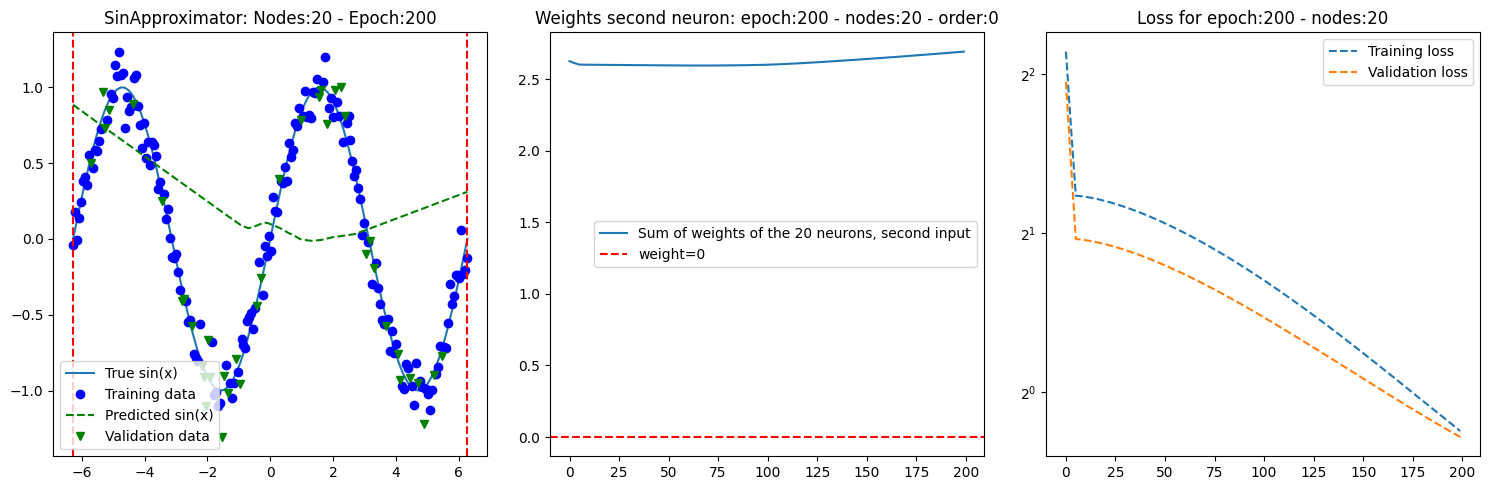

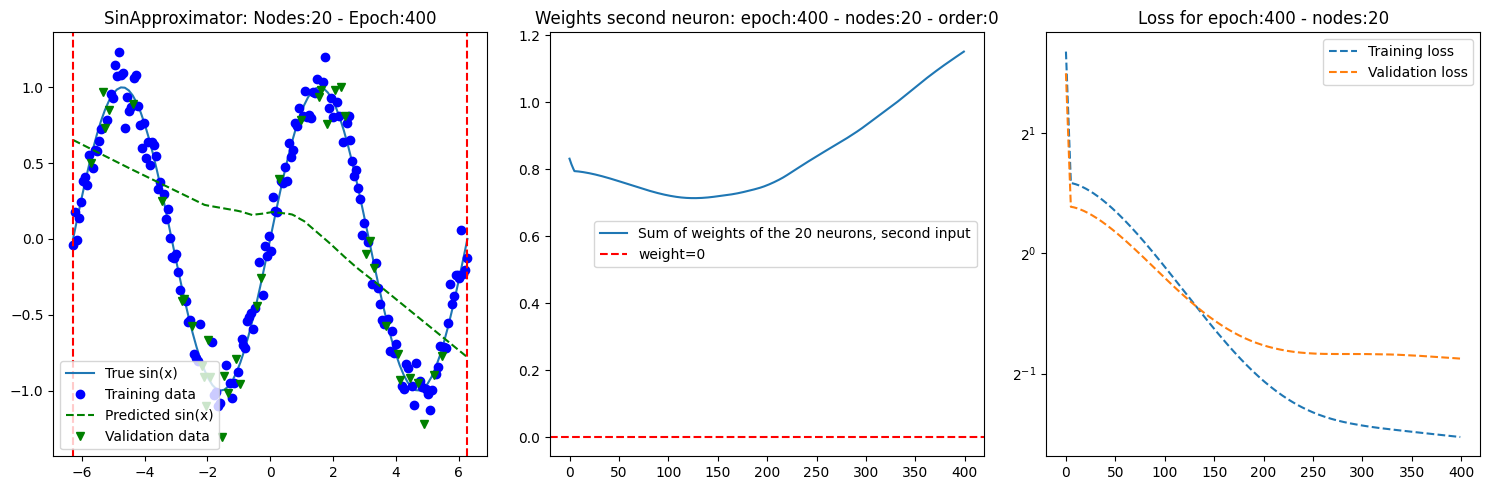

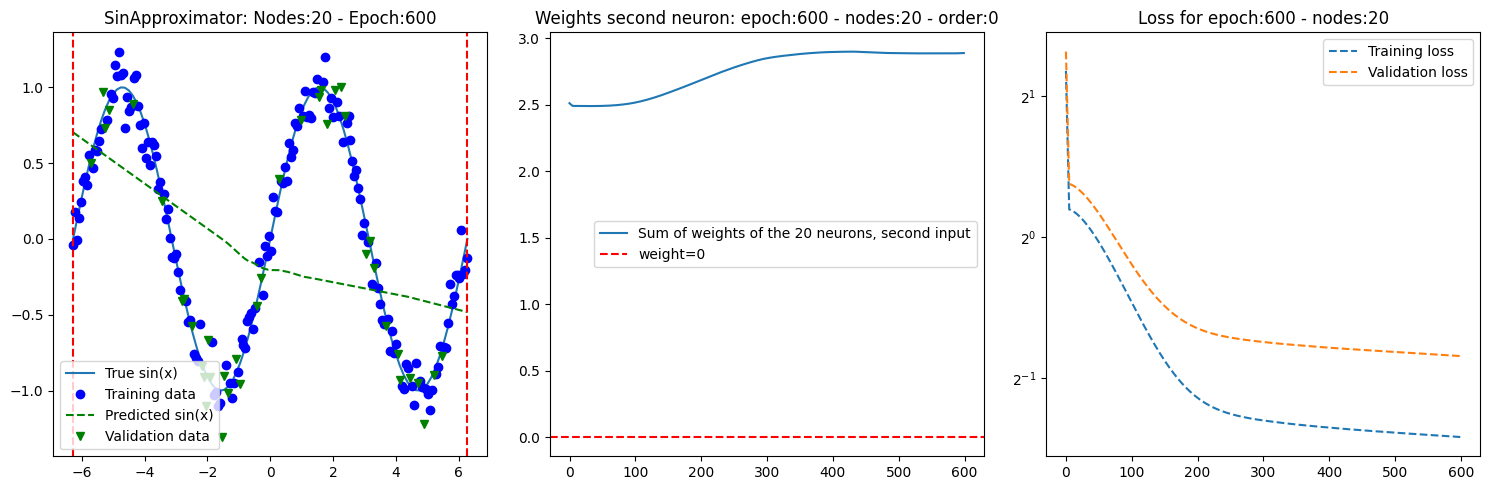

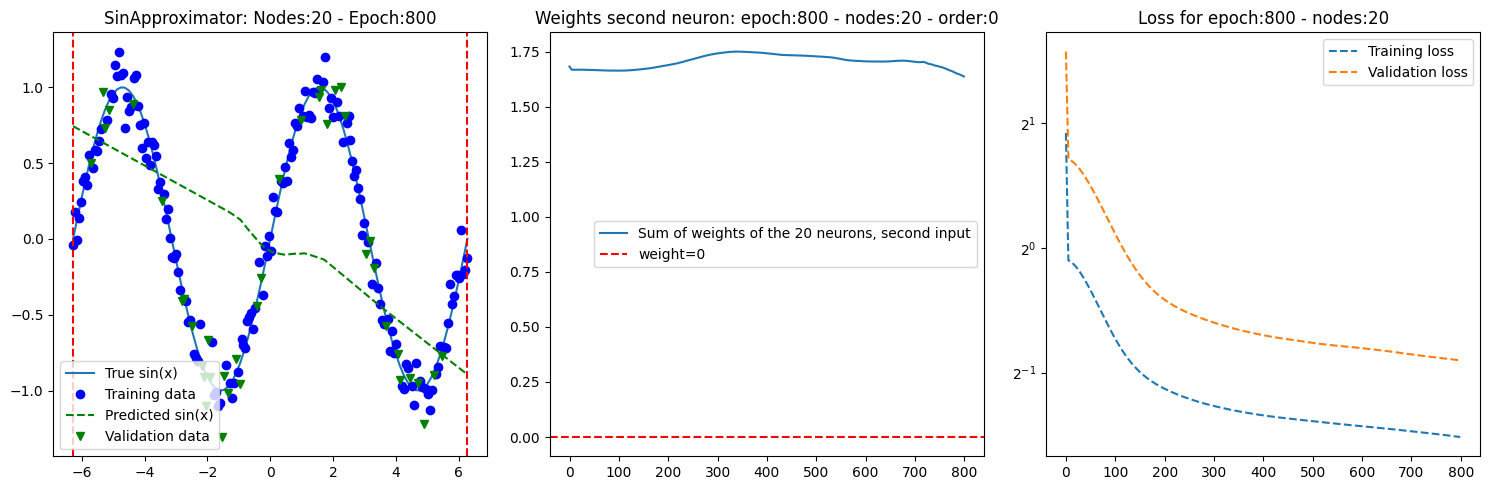

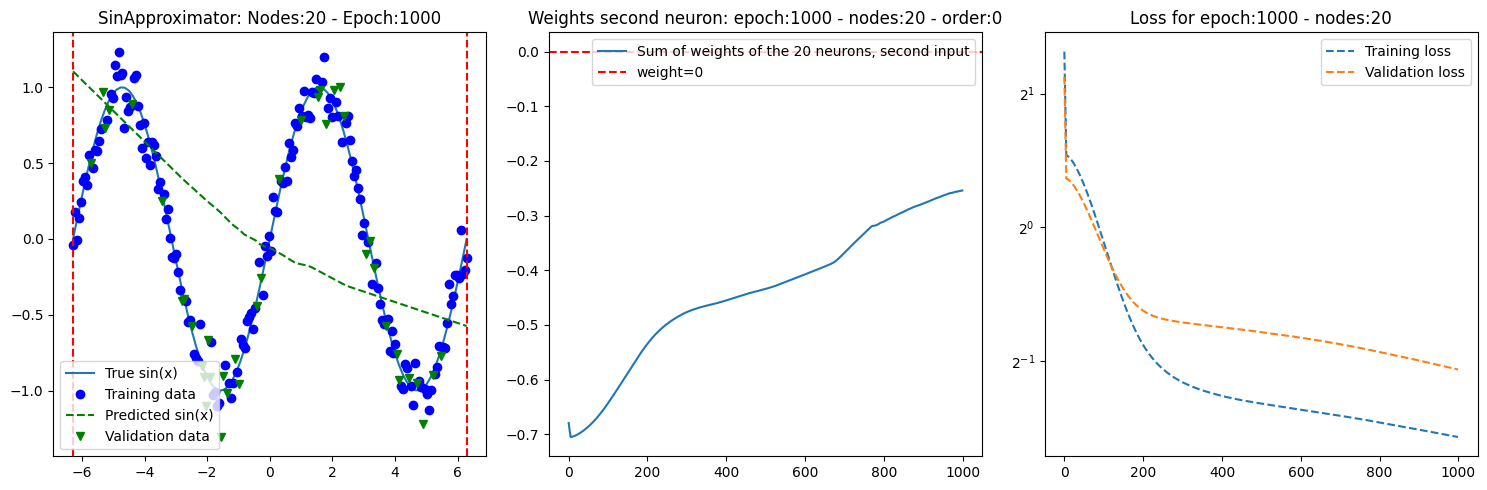

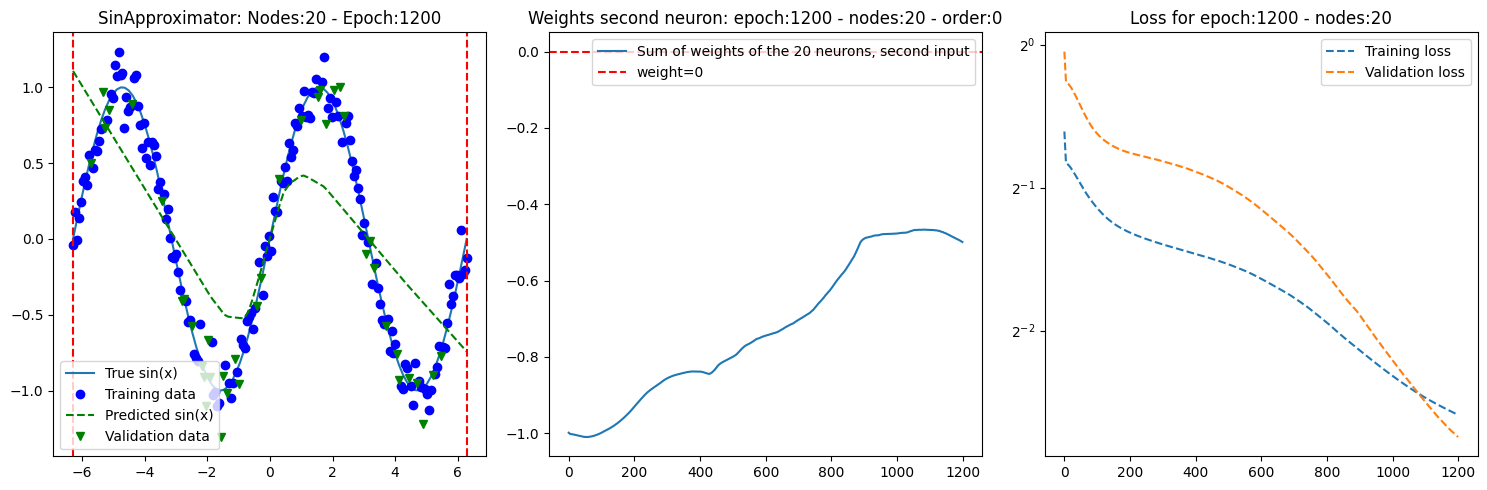

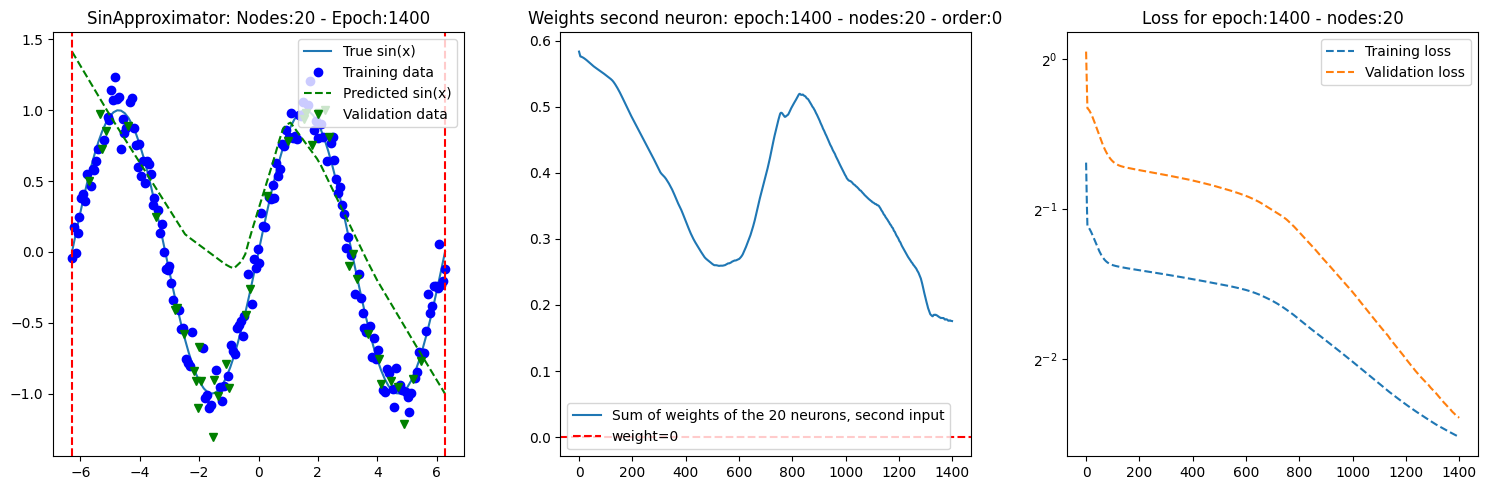

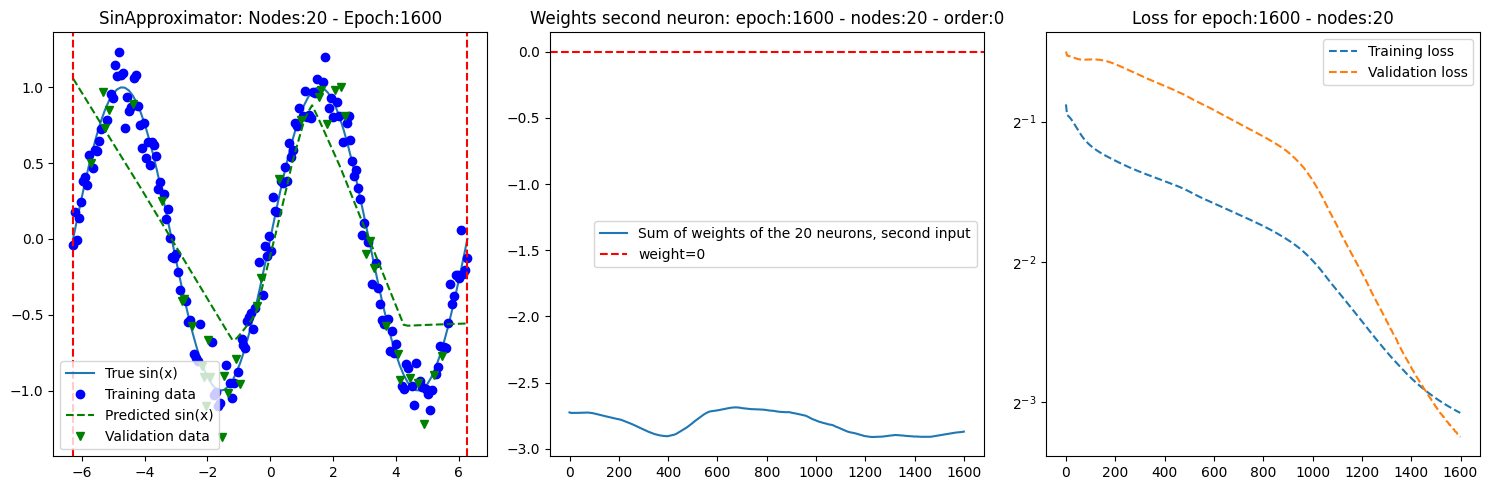

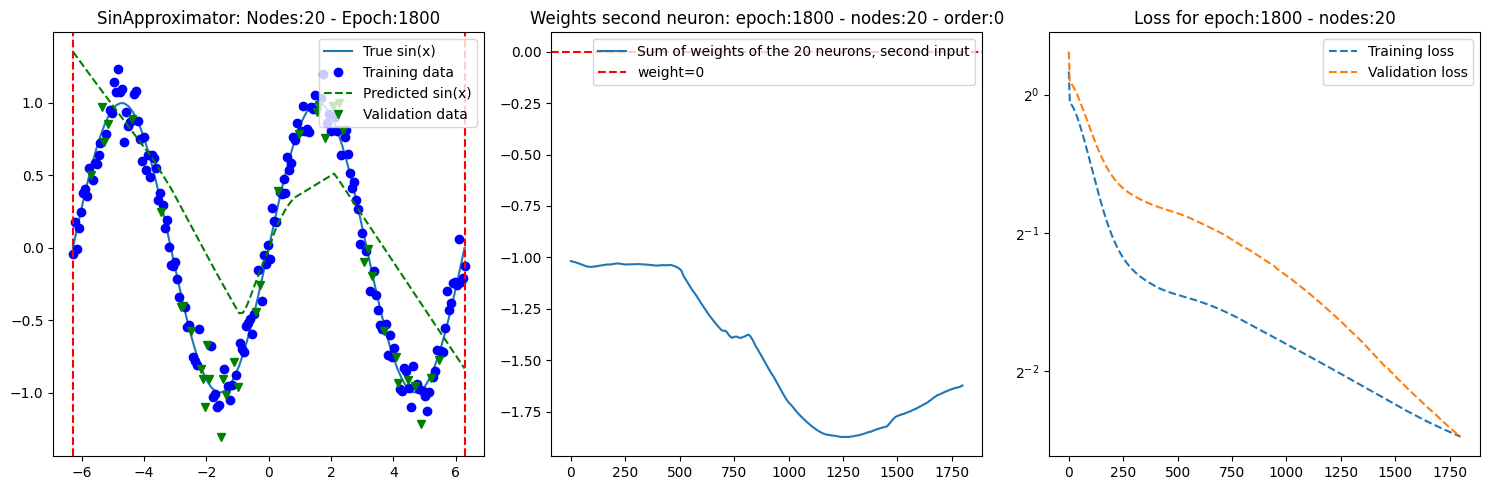

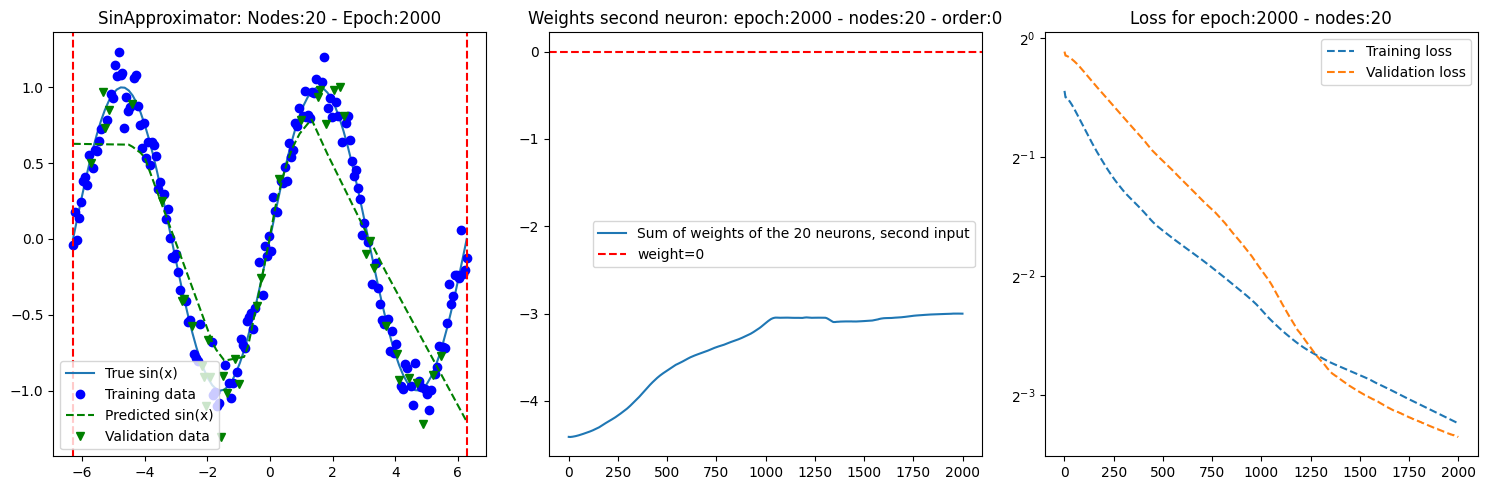

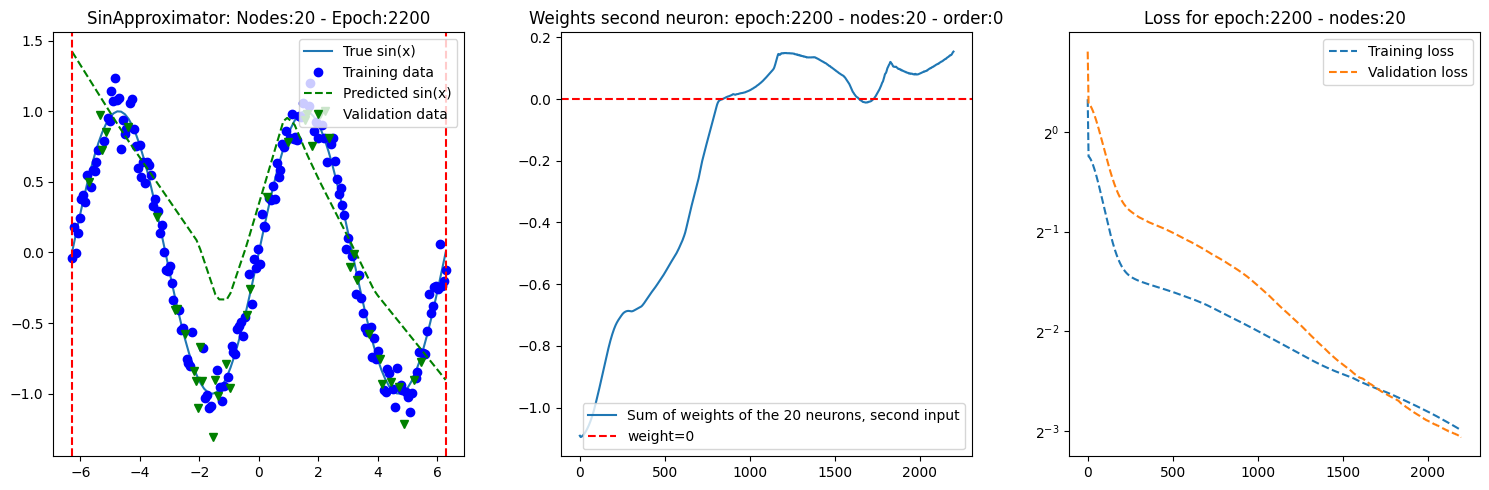

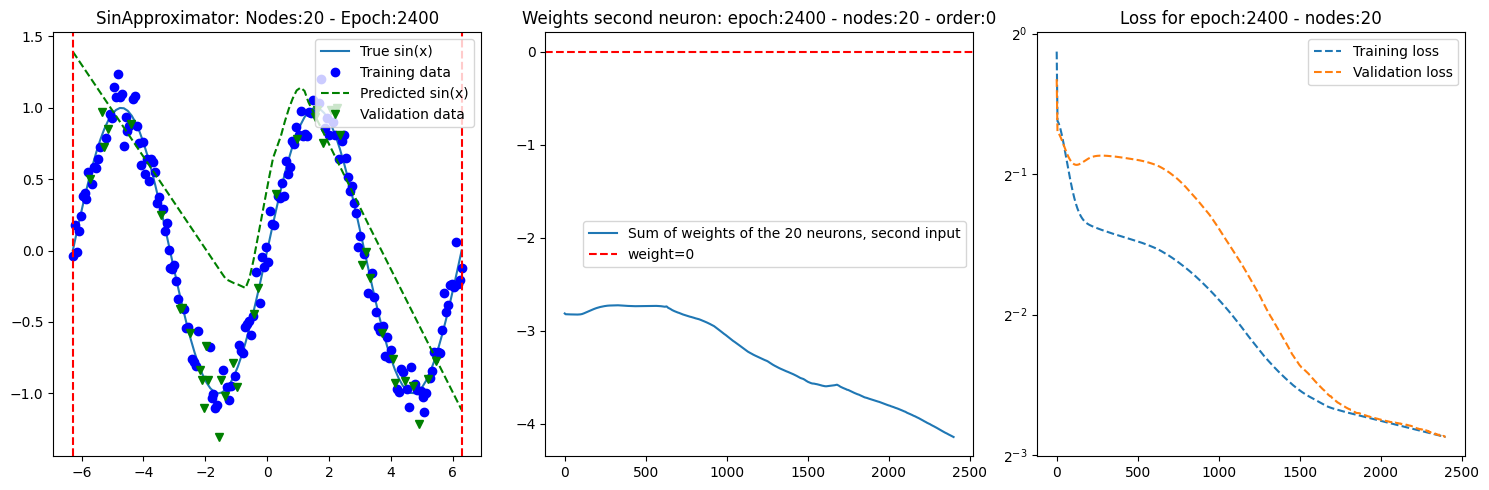

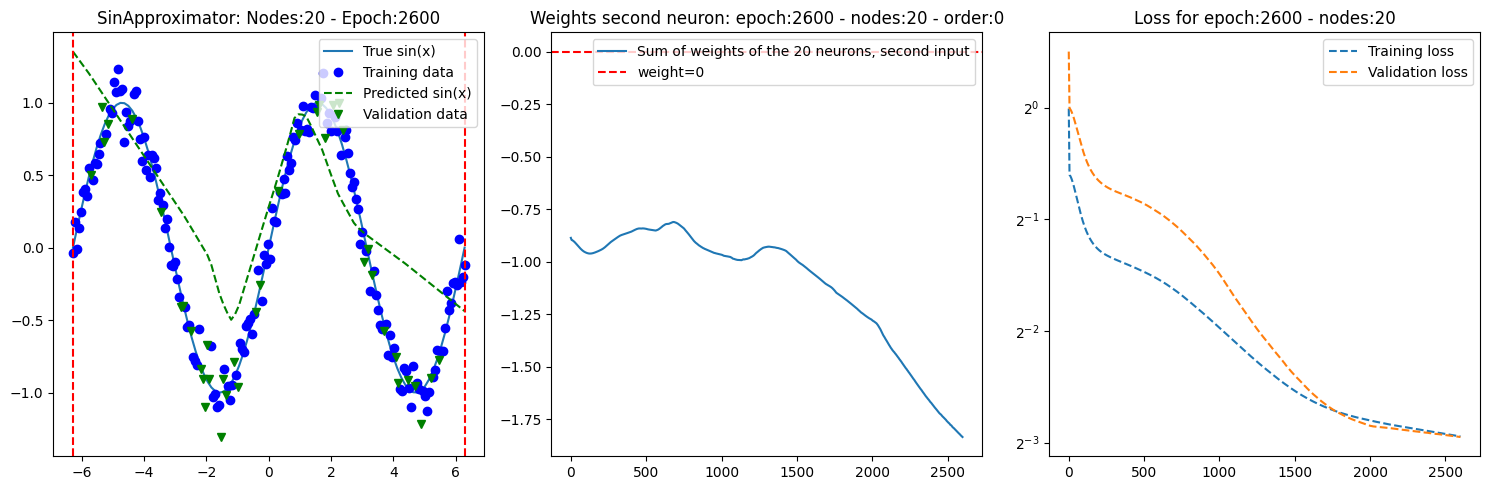

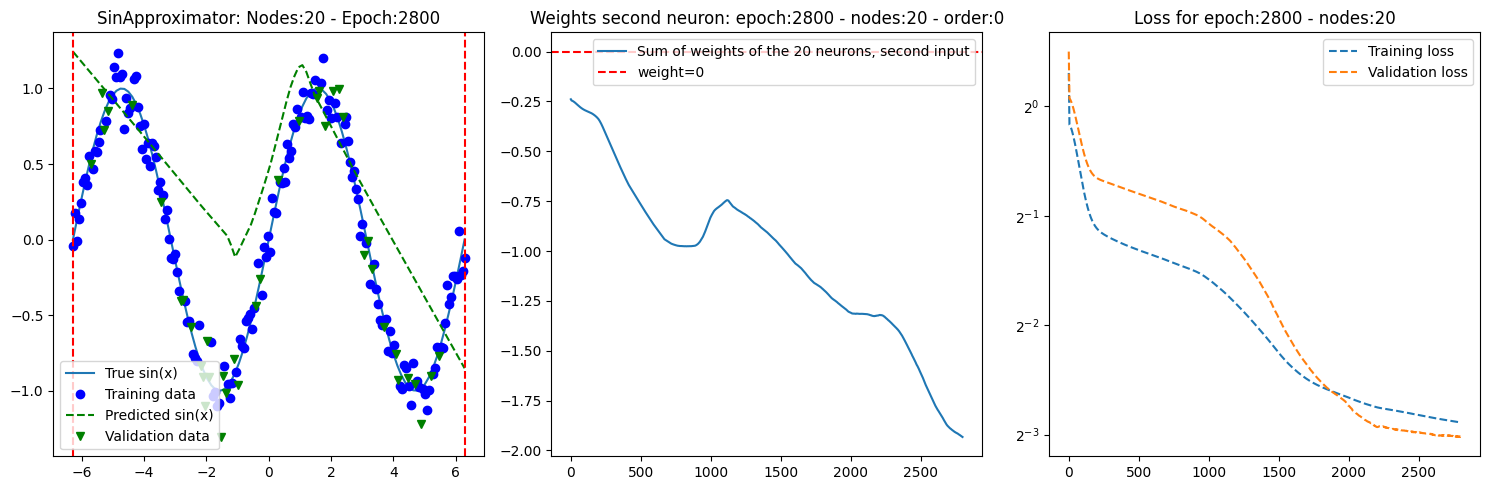

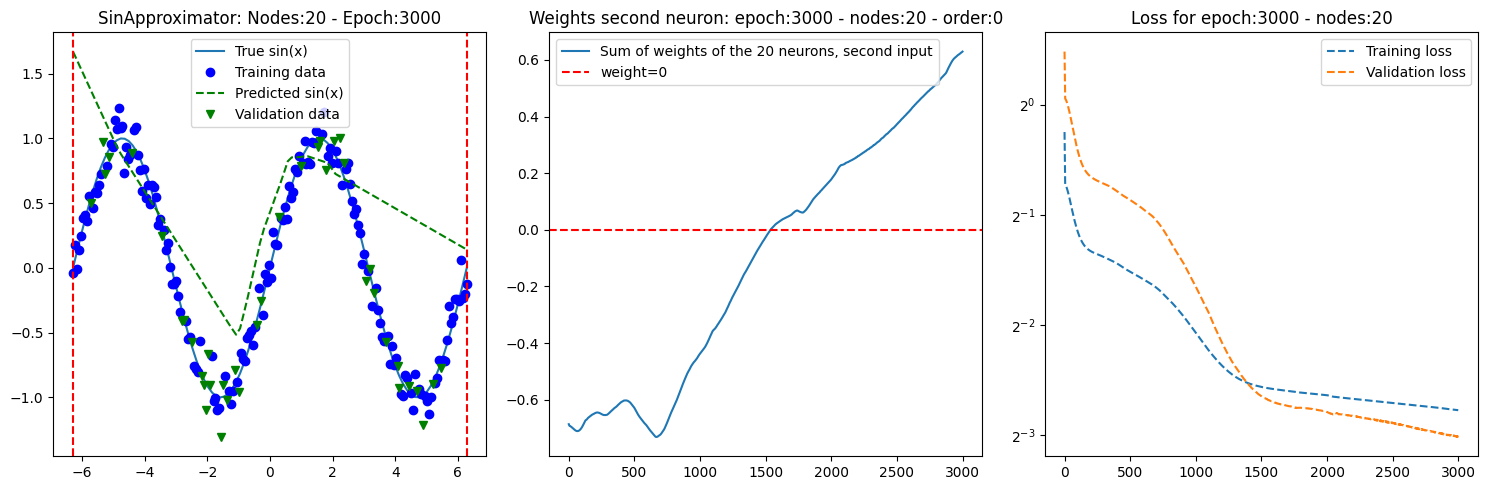

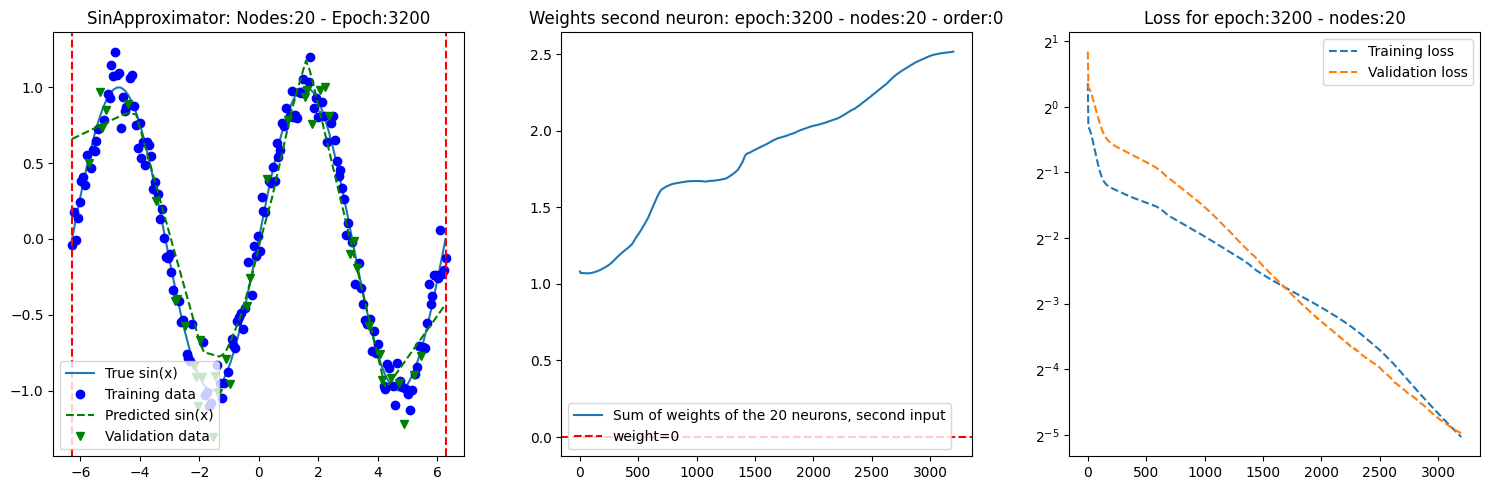

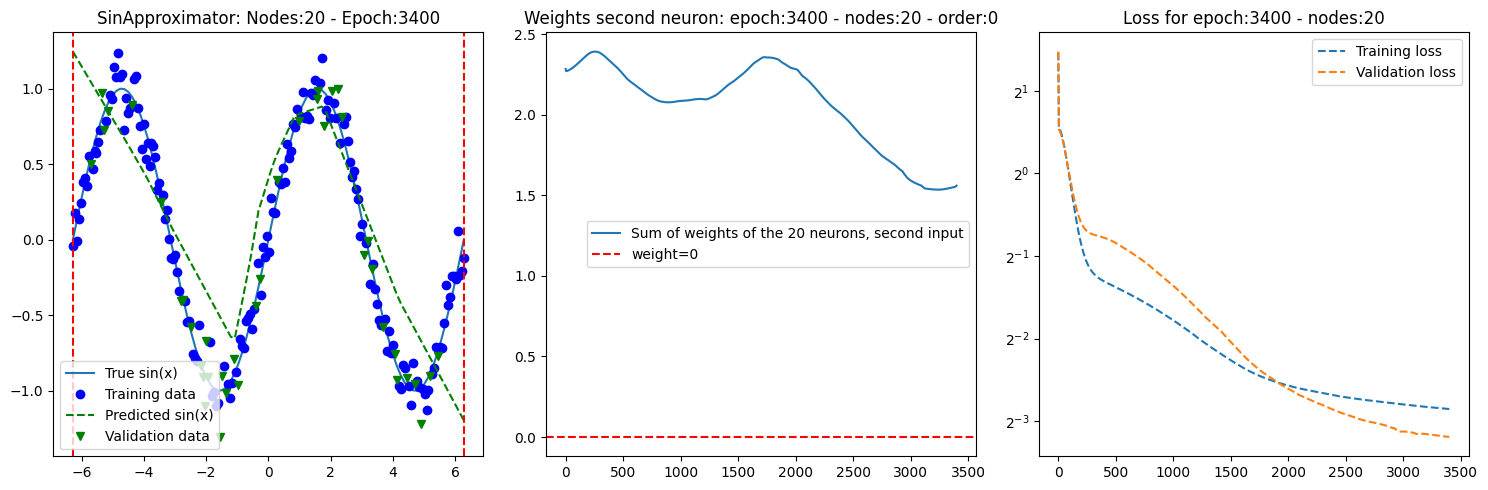

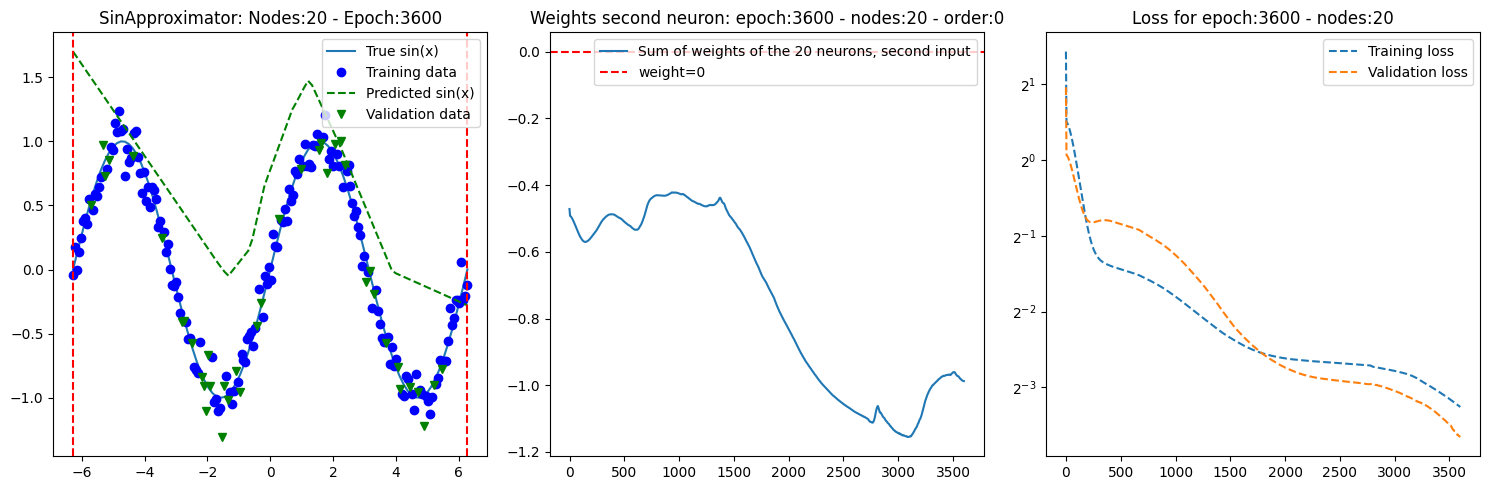

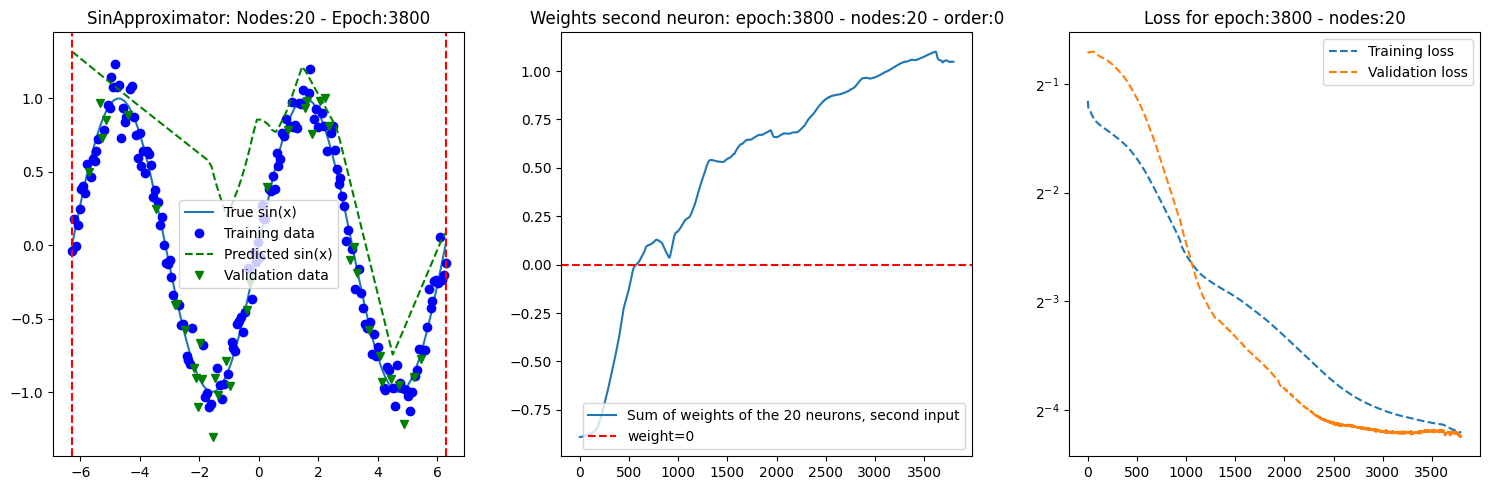

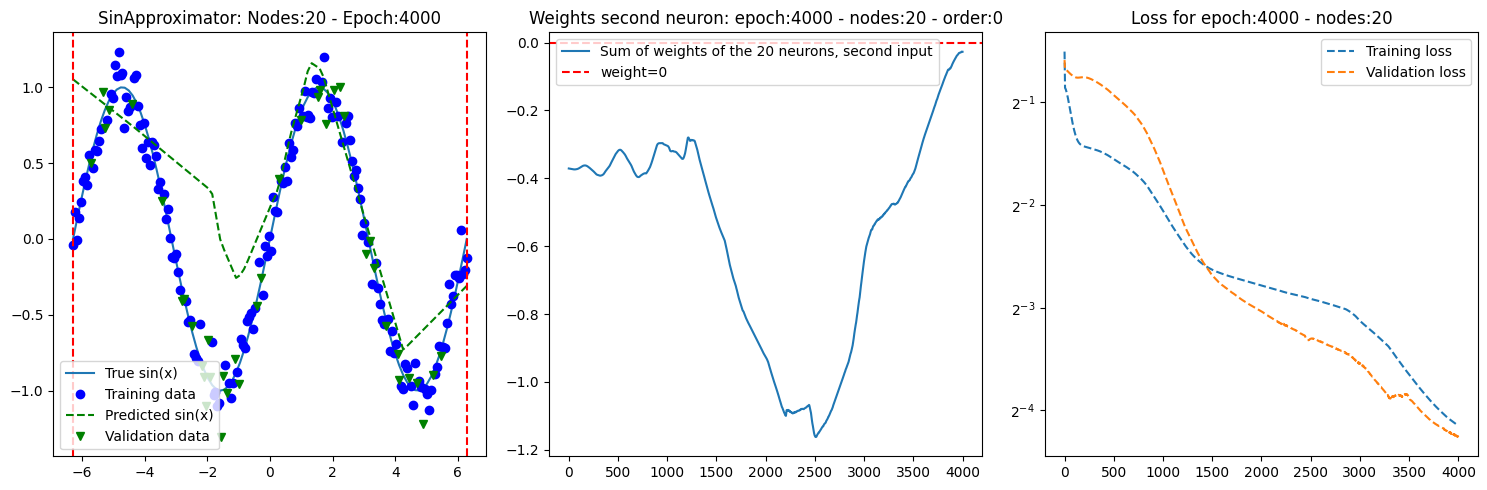

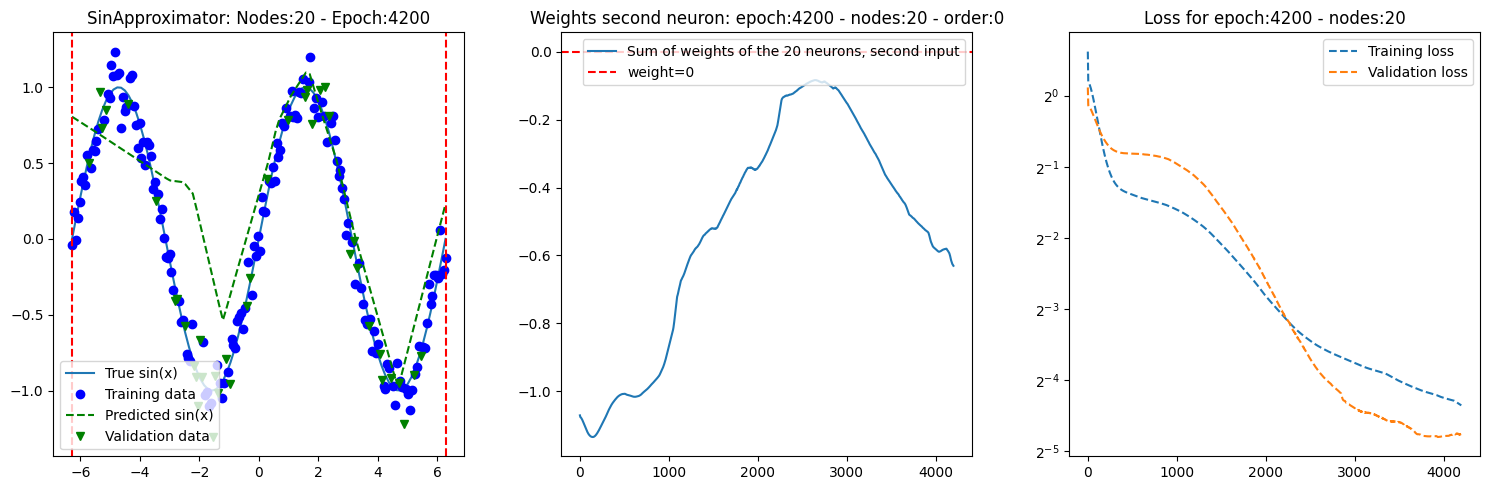

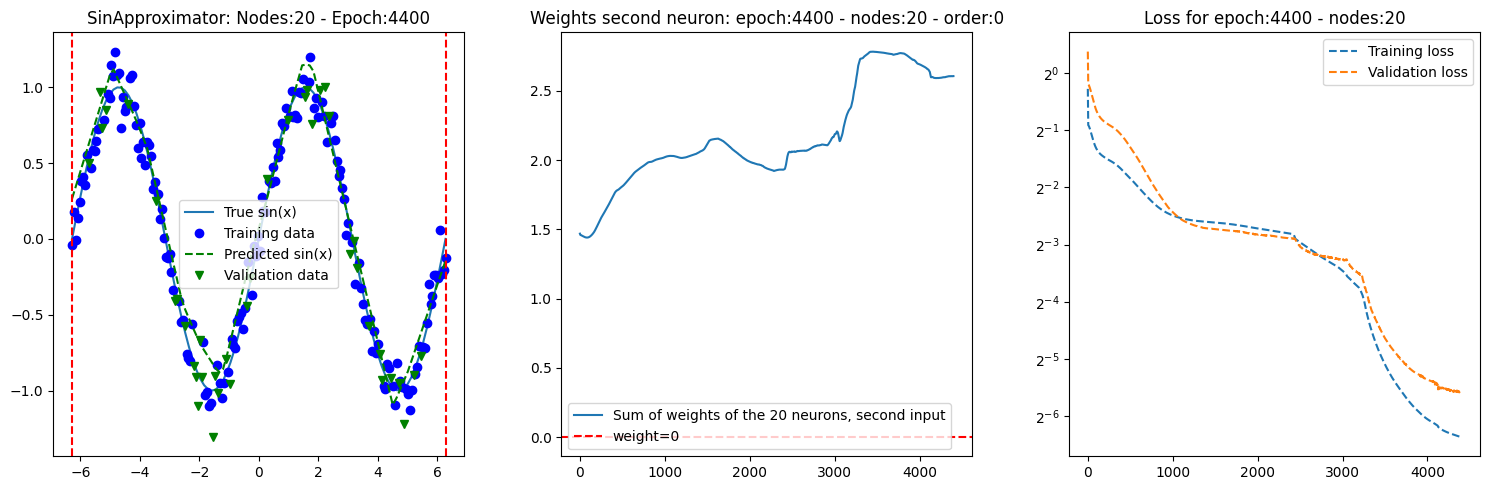

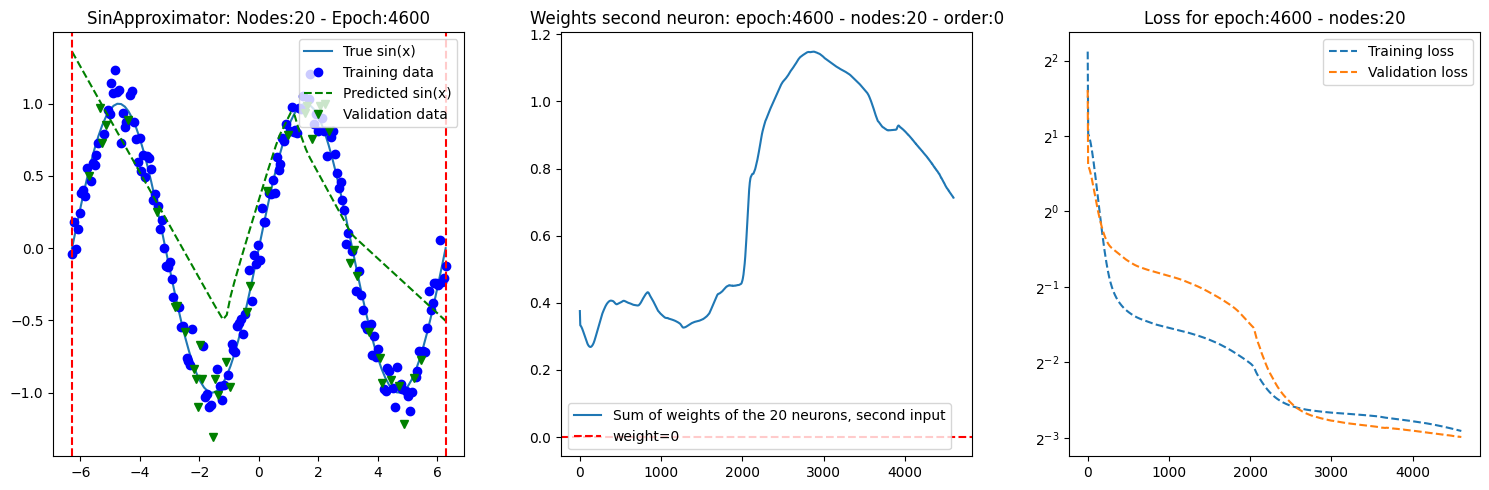

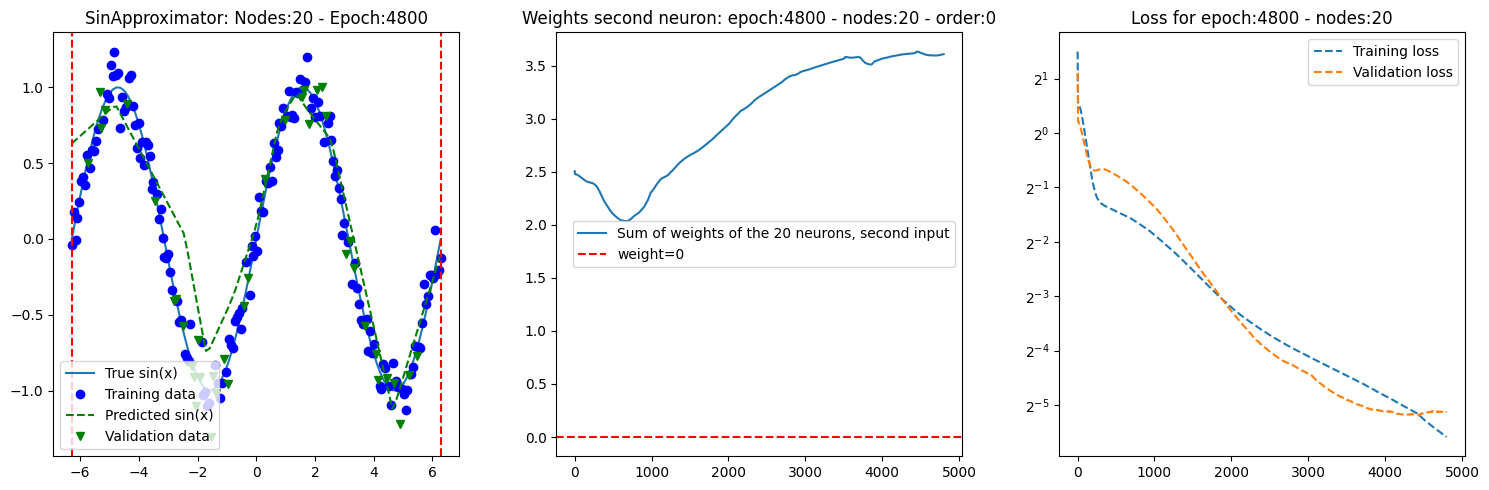

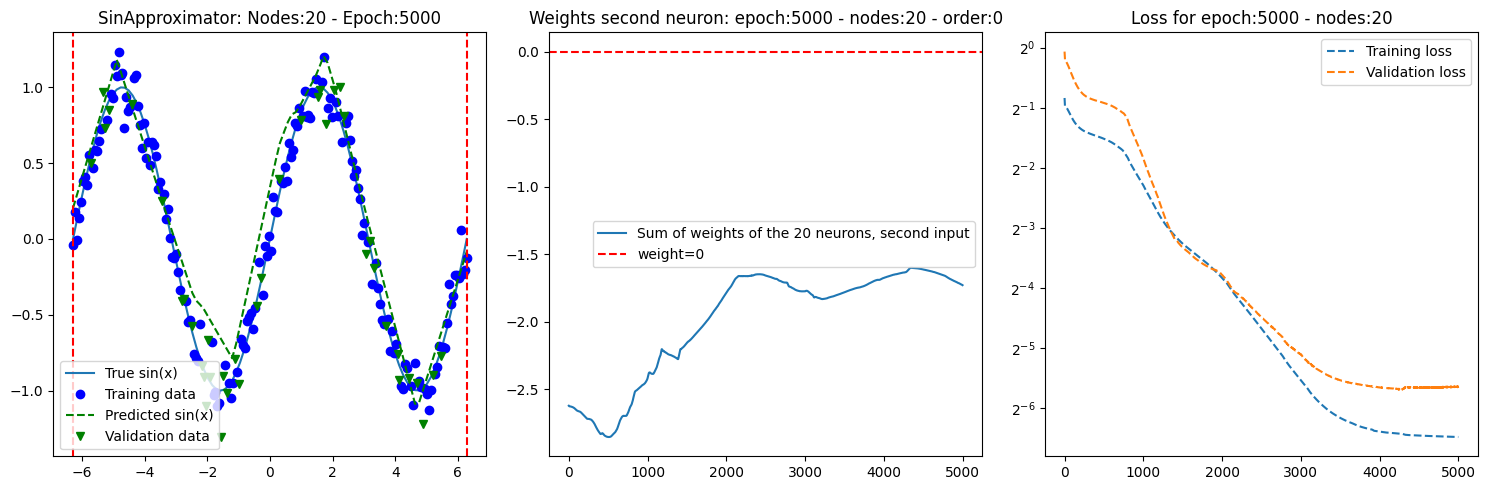

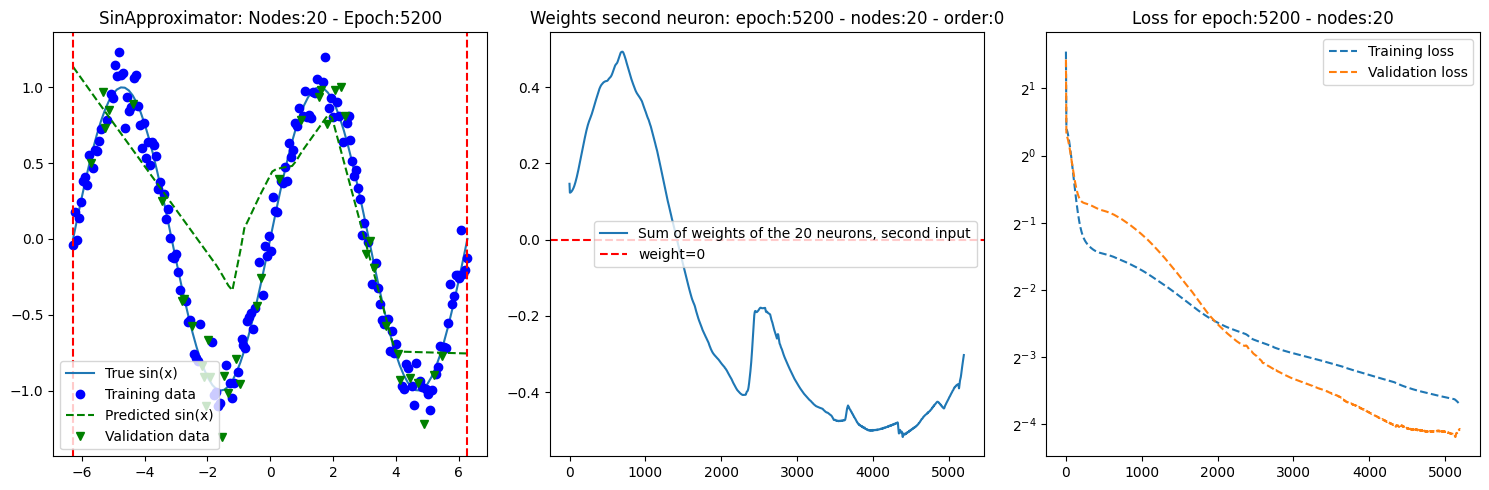

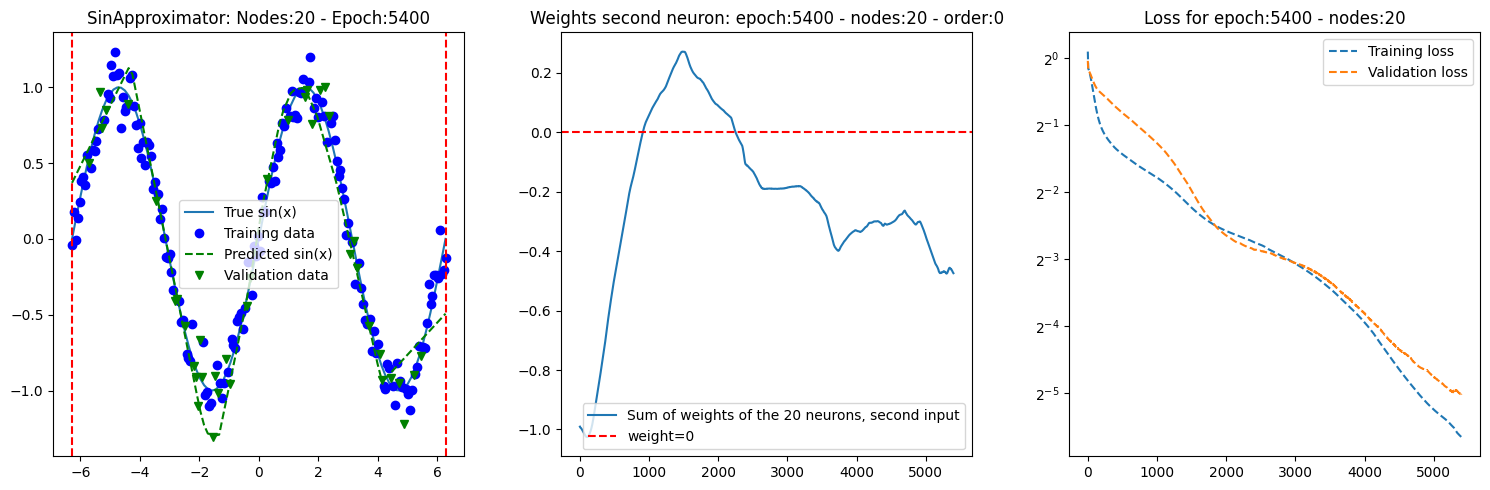

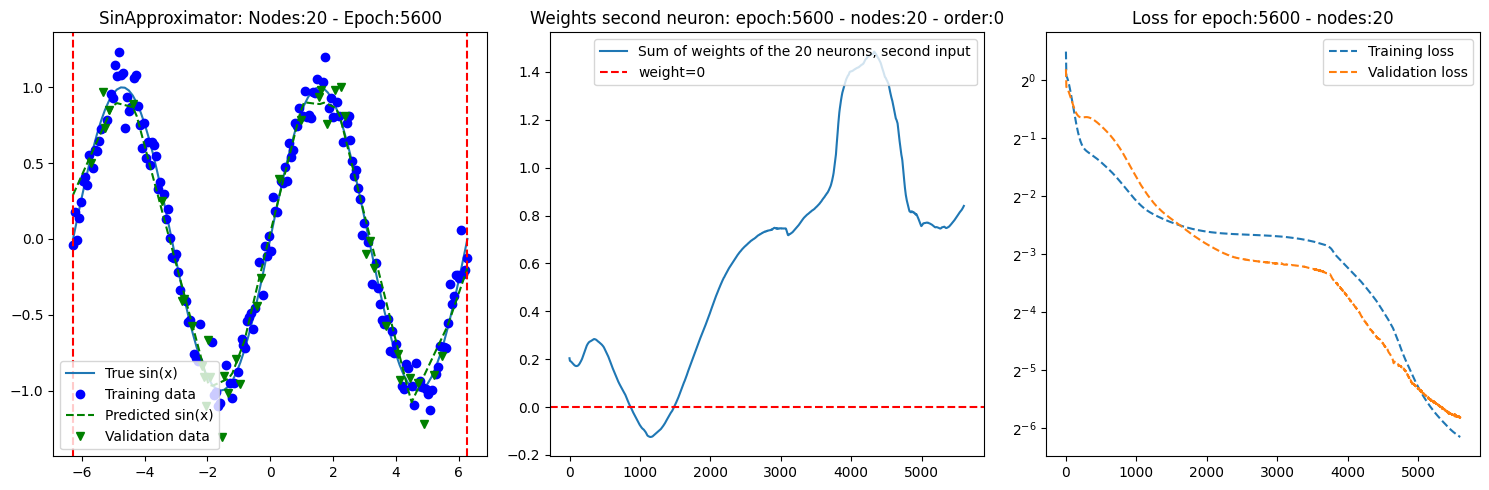

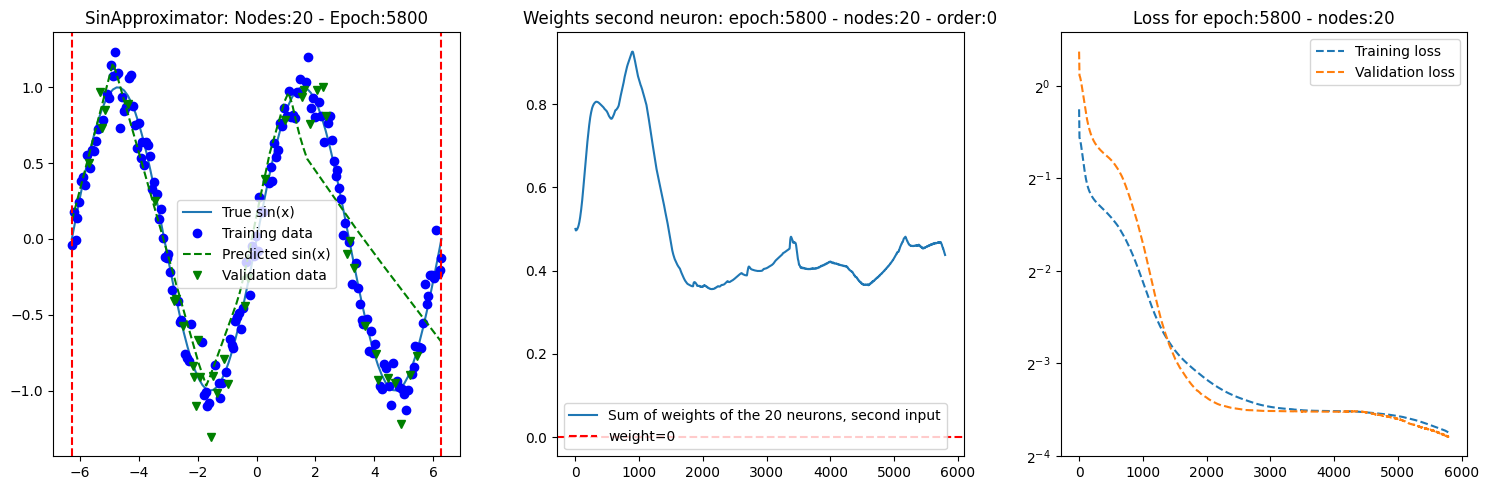

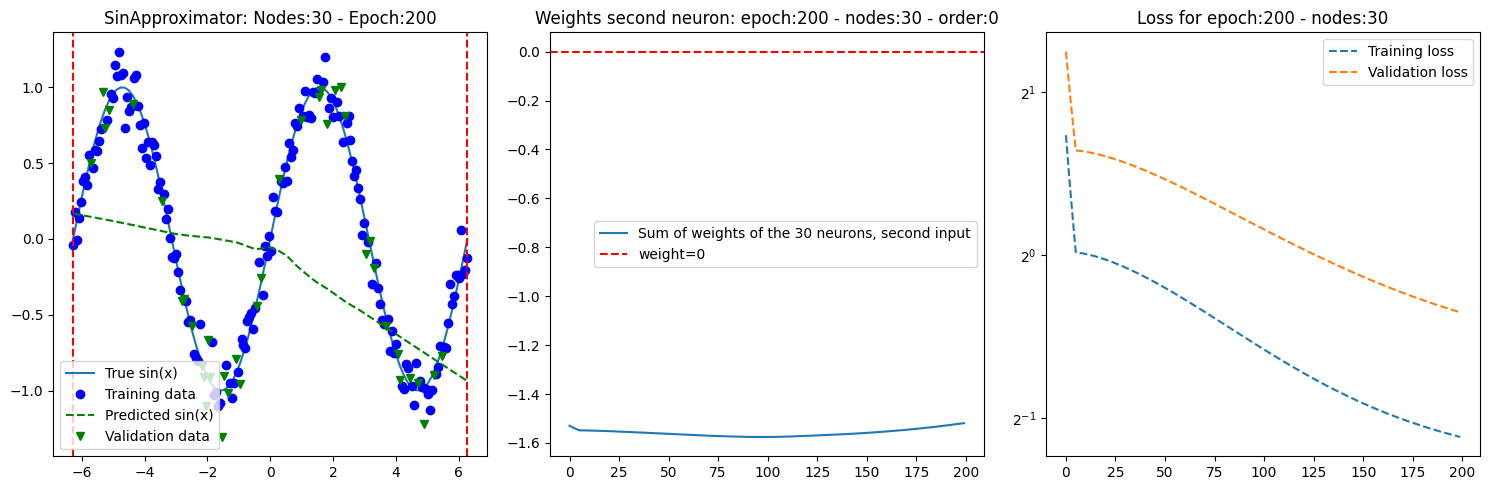

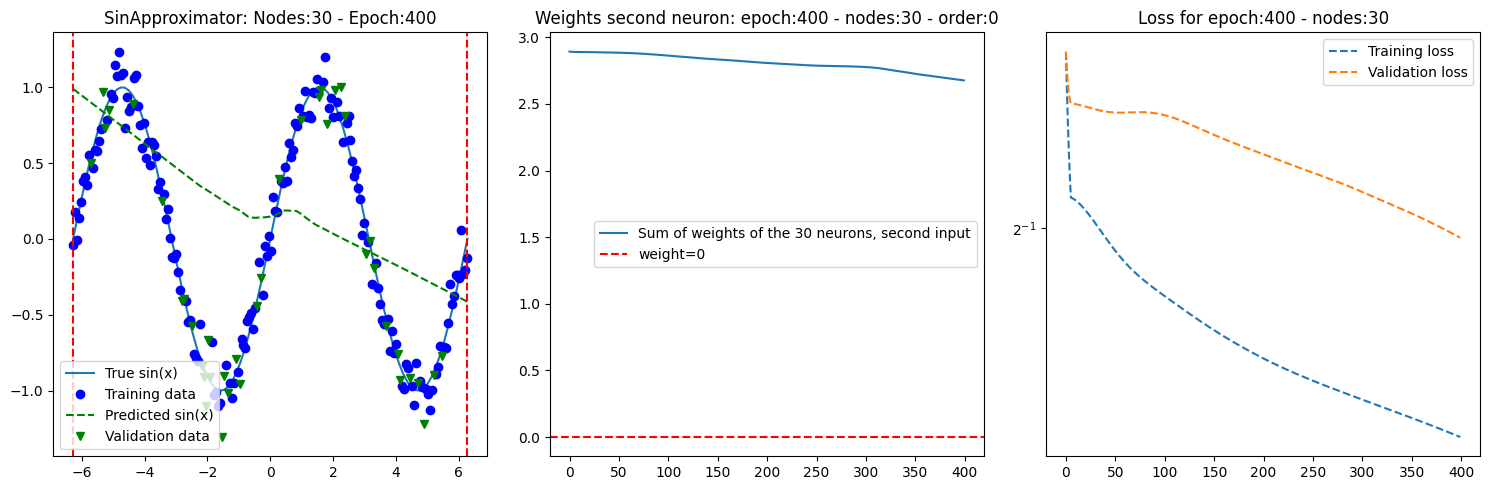

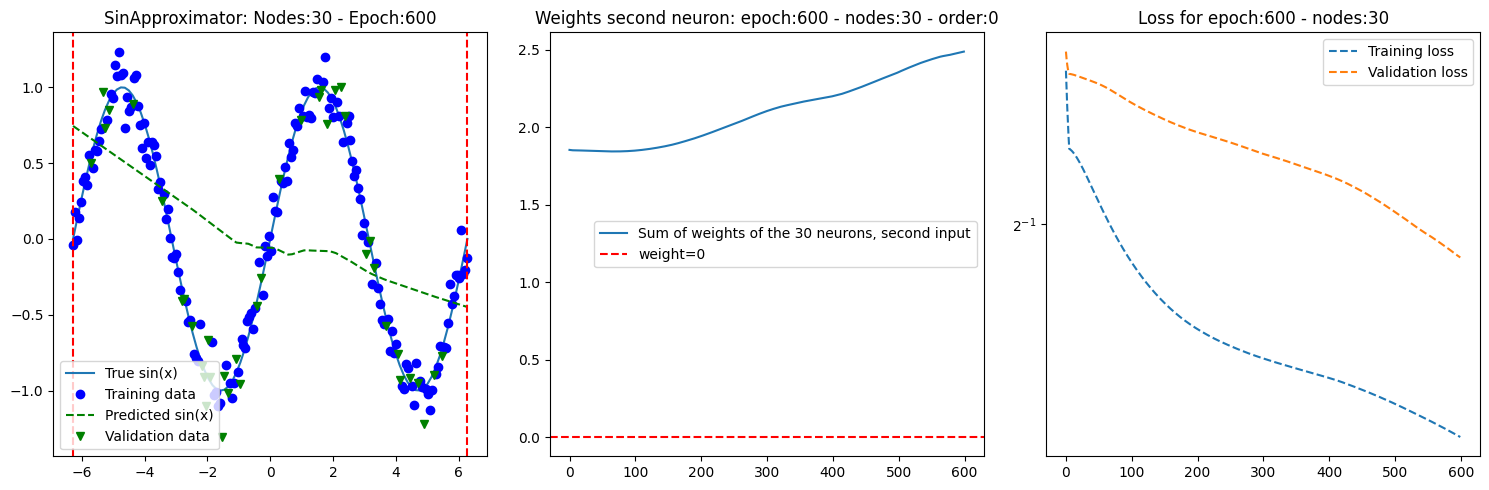

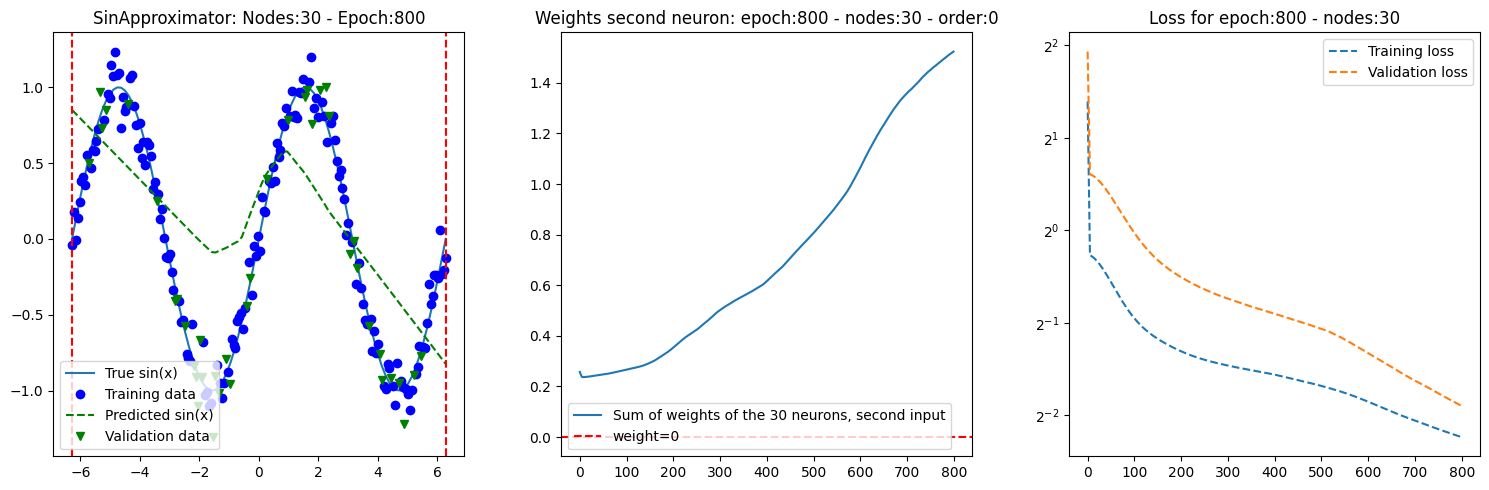

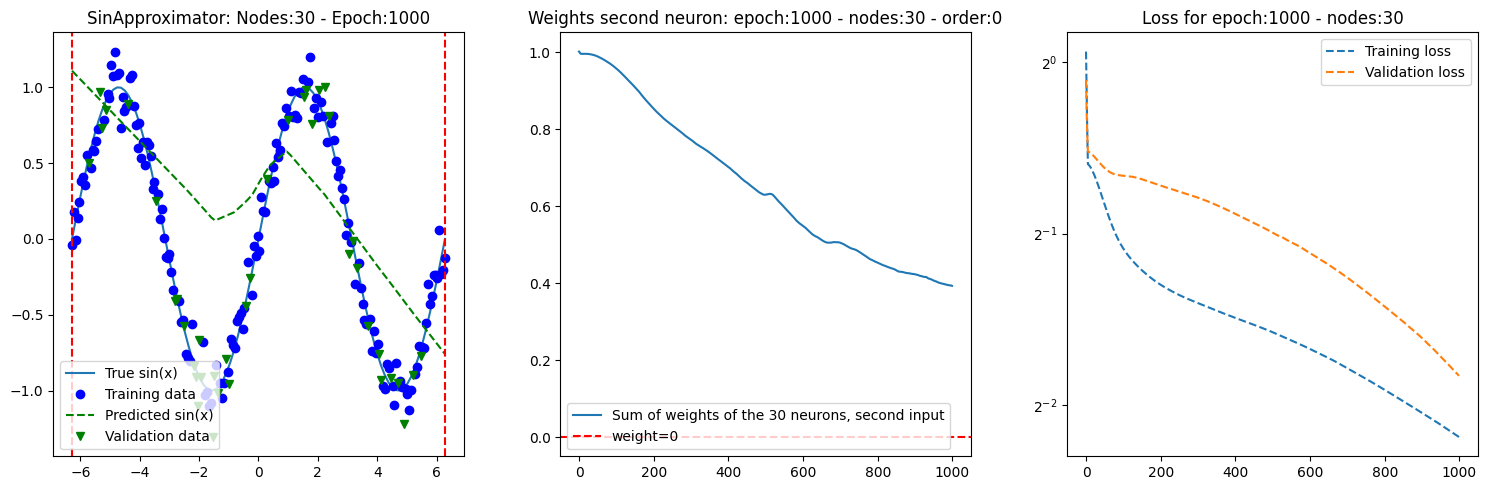

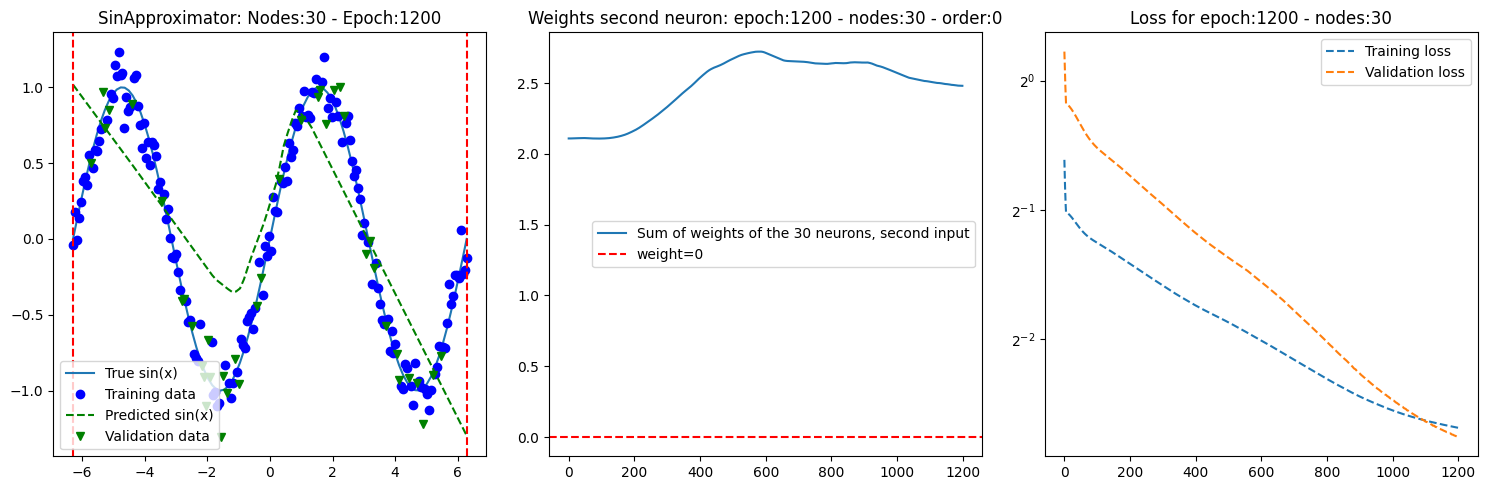

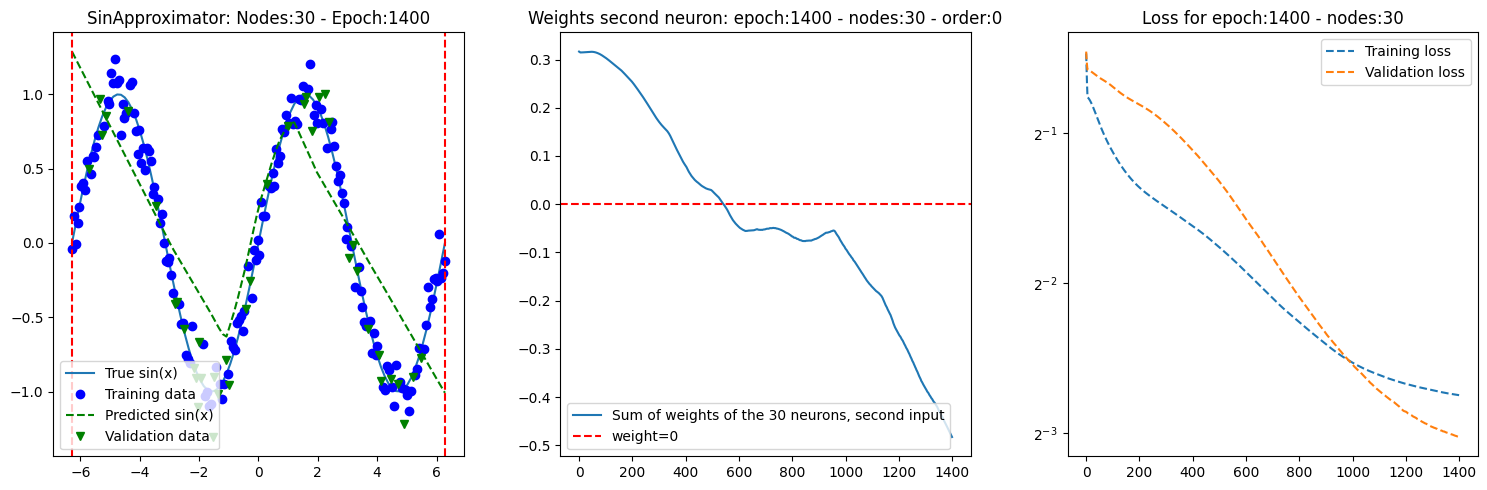

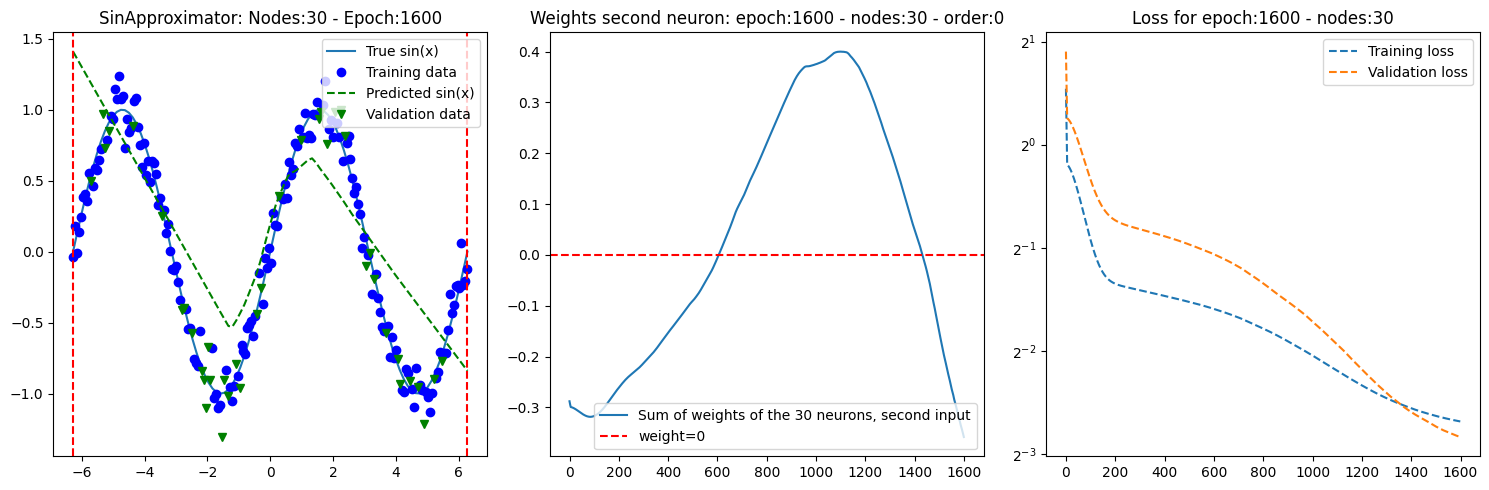

In [ ]:
# let's sample values to plot 
x_values = np.linspace(-interval *bit_much * np.pi, interval *bit_much * np.pi, 100)
x_values_ = np.vstack([x_values, np.zeros_like(x_values)])


X_train, y_train, X_val, y_val = generate_data(total_size=dataset_size, validation_ratio=validation_ratio, how="linspace")


for nodes in range(min_nodes, max_nodes+1, 10):
    for epoch_number in range(200, max_epoch, 200):
        for order in (0,): #1,2):
                    
            model = SinApproximator(nodes=nodes)


            # Train the model
            weights_b, train_loss, val_loss, validation_predicted = train(model, X_train, y_train, X_val, y_val, num_epochs=epoch_number, order=order)

            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

            with torch.no_grad():
                predictions = model(torch.tensor(x_values_.T, dtype=torch.float32)).numpy()

            plot(axes, x_values, X_train, y_train, predictions, X_val, y_val, 
                 weights_b, train_loss, val_loss, nodes=nodes, epoch_number=epoch_number, order=order)
